In [ ]:
#This block of code was used to debug the data, the .set files and the .fdt were not matching and some data has less/more data than expected 
from scipy.io import loadmat, savemat
import os

base_path = "Sleep_dep_dataset"


for i in range(1, 72): 
    patient_id = f"sub-{i:02d}"
    for session in ['1', '2']:  
        set_file_path = os.path.join(base_path, patient_id, f"ses-{session}", "eeg", f"{patient_id}_ses-{session}_task-eyesopen_eeg.set")
        fdt_file_path = os.path.join(base_path, patient_id, f"ses-{session}", "eeg", f"{patient_id}_ses-{session}_task-eyesopen_eeg.fdt")
        
        if not os.path.exists(set_file_path):
            print(f"Missing .set file: {set_file_path}")
            continue
        if not os.path.exists(fdt_file_path):
            print(f"Missing .fdt file: {fdt_file_path}")
            continue
    
        try:
            eeg_data = loadmat(set_file_path)['EEG']
            nbchan = eeg_data[0, 0]['nbchan'][0, 0]  
            pnts_set = eeg_data[0, 0]['pnts'][0, 0]  
            srate = eeg_data[0, 0]['srate'][0, 0]    
        except Exception as e:
            print(f"Error reading .set file: {set_file_path}, Error: {e}")
            continue

        expected_size = nbchan * pnts_set * 4  
        actual_size = os.path.getsize(fdt_file_path)
        pnts_actual = actual_size // (int(nbchan) * int(4))
        if pnts_set != pnts_actual:
            print(f"Mismatch for {patient_id}, Session {session}:")
            print(f"  - .set file points: {pnts_set}")
            print(f"  - .fdt file points: {pnts_actual}")
            print("channels", nbchan)
            print("sample rate", srate)
            # Fix the .set file metadata
            print(f"  -> Fixing .set file to match .fdt file points ({pnts_actual})")
            eeg_data[0, 0]['pnts'][0, 0] = pnts_actual
            try:
                savemat(set_file_path, {'EEG': eeg_data})
                print(f"  -> Fixed metadata in: {set_file_path}")
            except Exception as e:
                print(f"  -> Error saving fixed .set file: {e}")
        else:
            print(f"Patient {patient_id}, Session {session}: Metadata matches the .fdt file.")


In [ ]:
import mne

eeg_path = "Sleep_dep_dataset/sub-43/ses-2/eeg/new/sub-43_ses-2_task-eyesopen_eeg.set"
raw = mne.io.read_raw_eeglab(eeg_path, preload=True)

print(f"Sampling rate: {raw.info['sfreq']} Hz")
print(f"Data shape: {raw.get_data().shape}")  

raw.plot()


In [ ]:
#DOWNSAMPLE THE DATA THAT WAS 5000HZ
import mne
import os

datasets = [
    "Sleep_dep_dataset/sub-39/ses-2/eeg/sub-39_ses-2_task-eyesopen_eeg.set",
    "Sleep_dep_dataset/sub-44/ses-2/eeg/sub-44_ses-2_task-eyesopen_eeg.set",
    "Sleep_dep_dataset/sub-43/ses-2/eeg/sub-43_ses-2_task-eyesopen_eeg.set"
]

for file_path in datasets:
    print(f"Processing: {file_path}")

    raw = mne.io.read_raw_eeglab(file_path, preload=True)
    original_rate = raw.info['sfreq']
    print(f"Original sampling rate: {original_rate} Hz")

    # Downsample to 500 Hz
    new_rate = 500
    raw.resample(new_rate)
    print(f"Downsampled to: {raw.info['sfreq']} Hz")

    # Delete existing .set and .fdt files 
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"Deleted: {file_path}")
    fdt_file_path = file_path.replace(".set", ".fdt")
    if os.path.exists(fdt_file_path):
        os.remove(fdt_file_path)
        print(f"Deleted: {fdt_file_path}")

    raw.export(file_path, fmt='eeglab')
    print(f"Saved downsampled file: {file_path}")


In [ ]:
#calculation for power spectrum
import numpy as np
import matplotlib.pyplot as plt
import mne
import os

psd_normal = []
psd_sd = []

fmin, fmax = 2, 40  # Hz

for i in range(1, 72):
    patient_id = f"sub-{i:02d}"
    for session, condition in zip(['1', '2'], ['normal sleep', 'sleep deprivation']):
        eeg_path = os.path.join("Sleep_dep_dataset", patient_id, "ses-" + session, "eeg", patient_id + "_ses-" + session + "_task-eyesopen_eeg.set")
        
        if os.path.exists(eeg_path):
            raw = mne.io.read_raw_eeglab(eeg_path, preload=True)
            
            psd = raw.compute_psd(method="welch", fmin=fmin, fmax=fmax, n_fft=2048)
            psd_data = psd.get_data()  
            freqs = psd.freqs
            mean_psd = np.mean(psd_data, axis=0)  

            if condition == 'normal sleep':
                psd_normal.append(mean_psd)
            else:
                psd_sd.append(mean_psd)

psd_normal = np.array(psd_normal)
psd_sd = np.array(psd_sd)

mean_normal = np.mean(psd_normal, axis=0)
sem_normal = np.std(psd_normal, axis=0) / np.sqrt(psd_normal.shape[0])

mean_sd = np.mean(psd_sd, axis=0)
sem_sd = np.std(psd_sd, axis=0) / np.sqrt(psd_sd.shape[0])


In [ ]:
#PLOT FOR POWER SPECTRUM
plt.figure(figsize=(8, 6))
plt.plot(freqs, 10 * np.log10(mean_normal), label='Normal Sleep', color='magenta')
plt.fill_between(freqs, 10 * np.log10(mean_normal - sem_normal), 10 * np.log10(mean_normal + sem_normal), color='magenta', alpha=0.3)

plt.plot(freqs, 10 * np.log10(mean_sd), label='Sleep Deprivation', color='green')
plt.fill_between(freqs, 10 * np.log10(mean_sd - sem_sd), 10 * np.log10(mean_sd + sem_sd), color='green', alpha=0.3)

plt.xlabel('Frequency (Hz)')
plt.ylabel('Absolute Power (dB)')
plt.title('Comparison of Power Spectrum')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [33]:
#PREPROCESSING, BANDPASS FILTER, ICA, REMOVE BAD CHANNELS (electrodes), THRESHOLD FOR EPOCHS 
import numpy as np
import matplotlib.pyplot as plt
import mne
import os
import csv

psd_normal = []
psd_sd = []


fmin, fmax = 2, 40  # Hz

# Bandpass filter 
filter_low = 0.2   
filter_high = 45  

epoch_duration = 4.0  # seconds
total_epochs_normal = 0
total_epochs_SD = 0
total_rejected_epochs_normal= 0
total_rejected_epochs_SD = 0
datasets_with_all_epochs_rejected = 0
epoch_summary = []

output_dir = "preprocessed_epochs"
os.makedirs(output_dir, exist_ok=True)

for i in range(1, 72):
    patient_id = f"sub-{i:02d}"
    for session, condition in zip(['1', '2'], ['normal sleep', 'sleep deprivation']):
        eeg_path = os.path.join("Sleep_dep_dataset", patient_id, "ses-" + session, "eeg", patient_id + "_ses-" + session + "_task-eyesopen_eeg.set")
        
        if os.path.exists(eeg_path):
            # print(f"Processing: {eeg_path}")
            raw = mne.io.read_raw_eeglab(eeg_path, preload=True)
            
            # 10-20 international montage 
            montage = mne.channels.make_standard_montage('standard_1020')
            raw.set_montage(montage) 

            # bandpass filter 
            raw.filter(l_freq=filter_low, h_freq=filter_high, fir_design='firwin')
            
            # Detect bad channels based on signal deviations
            data = raw.get_data()  
            channel_means = np.mean(data, axis=1)  
            channel_stds = np.std(data, axis=1)  
            
            z_scores = (channel_means - np.mean(channel_means)) / np.std(channel_means)
            bads = [raw.info['ch_names'][i] for i, z in enumerate(z_scores) if abs(z) > 3]
            
            raw.info['bads'] = bads  
            
            # Interpolate bad channels 
            if bads:
                raw.interpolate_bads(reset_bads=True)
                # print(f"Interpolated bad channels: {bads}")
            
            # ICA
            ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter=800)
            ica.fit(raw)
            
            # fp1 and fp2 are ones near the eyes, use as refernece
            eog_indices, eog_scores = ica.find_bads_eog(raw, ch_name=['Fp1', 'Fp2'])
            ica.exclude.extend(eog_indices)

            raw = ica.apply(raw)

            epochs = mne.make_fixed_length_epochs(raw, duration=epoch_duration, preload=True)
            num_epochs = len(epochs)
            
            # reject epochs based on threshold, cite paper 
            reject_criteria = dict(eeg=200e-6 if condition == 'normal sleep' else 220e-6)
            epochs = epochs.drop_bad(reject=reject_criteria)
            num_rejected_epochs = num_epochs - len(epochs)

            if condition == 'normal sleep':
                total_rejected_epochs_normal += num_rejected_epochs
                total_epochs_normal += num_epochs
            elif condition == 'sleep deprivation':
                total_rejected_epochs_SD += num_rejected_epochs
                total_epochs_SD += num_epochs

            if len(epochs) == 0:
                datasets_with_all_epochs_rejected += 1
                # print(f"All epochs rejected for dataset: {eeg_path}. Skipping...")
                continue
            
            output_file = os.path.join(output_dir, f"{patient_id}_ses-{session}_retained-epochs.fif")
            epochs.save(output_file, overwrite=True)

            epoch_summary.append({
                "Patient ID": patient_id,
                "Session": session,
                "Condition": condition,
                "Total Epochs": num_epochs,
                "Rejected Epochs": num_rejected_epochs,
                "Retained Epochs": len(epochs)
            })
            psd = epochs.compute_psd(method="welch", fmin=fmin, fmax=fmax, n_fft=2000)
            psd_data = psd.get_data()  
            freqs = psd.freqs
            psd_mean = np.mean(psd_data, axis=(0, 1)) 
            
            num_epochs = len(epochs)
            num_rejected_epochs = num_epochs - len(epochs)

            if condition == 'normal sleep':
                psd_normal.append(psd_mean)
            else:
                psd_sd.append(psd_mean)

psd_normal = np.array(psd_normal)
psd_sd = np.array(psd_sd)

mean_normal = np.mean(psd_normal, axis=0)
sem_normal = np.std(psd_normal, axis=0) / np.sqrt(psd_normal.shape[0])

mean_sd = np.mean(psd_sd, axis=0)
sem_sd = np.std(psd_sd, axis=0) / np.sqrt(psd_sd.shape[0])

output_file = "epoch_rejection_summary.csv"
with open(output_file, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=["Patient ID", "Session", "Condition", "Total Epochs", "Rejected Epochs", "Retained Epochs"])
    writer.writeheader()
    writer.writerows(epoch_summary)


Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-01\ses-1\eeg\sub-01_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 1 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 2.7s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
0 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-01_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-01\ses-2\eeg\sub-01_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 113955  =      0.000 ...   227.910 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 19.8s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 

c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 sam

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


0 projection items activated
Using data from preloaded Raw for 56 events and 2000 original time points ...
0 bad epochs dropped
0 bad epochs dropped
Effective window size : 4.000 (s)


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-01_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-02\ses-1\eeg\sub-02_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 9.6s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['AF7', 'P7']
    Rejecting  epoch based on EEG : ['AF7', 'C3']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['AF3', 'AF7', 'Fz', 'F3', 'F5', 'F7', 'FC3', 'FC5', 'FT7', 'C3', 'C5', 'CP3', 'CP5', 'TP7', 'TP9', 'P5', 'O1', 'AF4', 'F6', 'F8', 'FC4', 'FC6', 'FT8', 'C6', 'T8', 'CPz', 'CP6', 'TP8', 'TP10', 'POz']
6 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-02_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-02\ses-2\eeg\sub-02_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 1 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 38.2s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 sam

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2', 'AF4', 'AF8', 'F6', 'F8']
8 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-02_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-03\ses-1\eeg\sub-03_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 2.6s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['F7', 'FC3', 'FT7', 'C3', 'C5', 'T7', 'CP5', 'TP7', 'AF8', 'F8', 'FC6', 'FT8', 'T8', 'TP8']
    Rejecting  epoch based on EEG : ['TP9', 'TP10']
    Rejecting  epoch based on EEG : ['AF7', 'F5', 'F7', 'FC3', 'FC5', 'FT7', 'C3', 'C5', 'T7', 'CP5', 'TP7', 'P7', 'AF8', 'F8', 'FC4', 'FC6', 'FT8', 'C4', 'C6', 'T8', 'CP6', 'TP8']
    Rejecting  epoch based on EEG : ['F7', 'T7', 'TP9', 'TP10']
    Rejecting  epoch based on EEG : ['TP9', 'TP10']
5 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-03_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-03\ses-2\eeg\sub-03_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.5s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['F7', 'FC5', 'T7', 'F8', 'FT8', 'T8']
    Rejecting  epoch based on EEG : ['TP7', 'TP9', 'P7', 'PO7', 'O1', 'T8', 'TP8', 'TP10', 'P4', 'POz', 'PO4', 'PO8', 'O2']
3 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-03_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-04\ses-2\eeg\sub-04_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 38.1s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target


c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['Fz', 'O1']
    Rejecting  epoch based on EEG : ['Fz', 'O1']
    Rejecting  epoch based on EEG : ['O1', 'F8']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['Fz', 'O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epo

C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-04_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-05\ses-1\eeg\sub-05_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 1 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 37.8s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 sam

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
0 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-05_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-05\ses-2\eeg\sub-05_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 1 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 38.2s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 sam

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
0 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-05_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-06\ses-1\eeg\sub-06_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 37.8s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 sam

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['AF8']
1 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-06_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-06\ses-2\eeg\sub-06_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 4.2s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['P3', 'PO3', 'PO4']
    Rejecting  epoch based on EEG : ['P3']
    Rejecting  epoch based on EEG : ['P3', 'PO7', 'P8']
    Rejecting  epoch based on EEG : ['P3']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['Fz', 'F7', 'O1', 'AF4', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F7', 'O1', 'AF4', 'F8']
9 bad epochs dropped
Effective window size : 4.000 (s)


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-06_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-07\ses-1\eeg\sub-07_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 2.8s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['TP7', 'TP9']
    Rejecting  epoch based on EEG : ['TP7', 'TP9', 'Pz']
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['AF8', 'F8']
4 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-07_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-07\ses-2\eeg\sub-07_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 1 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 37.8s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 sam

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 61 PCA components
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['C5']
    Rejecting  epoch based on EEG : ['C5']
    Rejecting  epoch based on EEG : ['C5']
    Rejecting  epoch based on EEG : ['C5']
    Rejecting  epoch based on EEG : ['C5']
    Rejecting  epoch based on EEG : ['C5']
    Rejecting  epoch based on EEG : ['AF3', 'Fpz']
    Rejecting  epoch based on EEG : ['AF3', 'Fz', 'Fpz']
    Rejecting  epoch based on EEG : ['AF3', 'Fpz']
    Rejecting  epoch based on EEG : ['AF3', 'Fpz']
    Rejecting  epoch based on EEG : ['Fpz']
    Rejecting  epoch based on EEG : ['AF3', 'Fpz']
    Rejecting  epoch based on EEG : ['AF3', 'Fpz']
    Rejecting  epoch based on EEG : ['AF3', 'Fpz']
    Rejecting  epoch based on EEG : ['C5', 'Fpz']
    Rejecting  epoch based on EEG : ['AF3', 'C5', 'Fpz']
    Rejecting  epoch based on EEG : ['Fpz']


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-07_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-08\ses-1\eeg\sub-08_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 59 sensor positions
Interpolating 2 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 38.1s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 sam

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 61 PCA components
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EE

C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-08_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-08\ses-2\eeg\sub-08_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 59 sensor positions
Interpolating 2 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 38.0s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 sam

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['F7', 'FT7', 'TP9', 'TP10', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'F7']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F7', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2', 'AF8']
    Rejecting 

C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-08_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-09\ses-1\eeg\sub-09_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 58 sensor positions
Interpolating 3 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.6s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['PO4', 'PO8']
    Rejecting  epoch based on EEG : ['T7', 'Fp2', 'AF8', 'F8']
    Rejecting  epoch based on EEG : ['F5', 'F7', 'FT7', 'T7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F5', 'F7', 'FC5', 'FT7', 'C5', 'T7', 'CP5', 'TP7', 'Fp2', 'AF8', 'F4', 'F6', 'F8', 'FC4', 'FC6', 'FT8', 'C4', 'C6', 'T8', 'CP6', 'TP10']
    Rejecting  epoch based on EEG : ['AF8', 'F6', 'F8', 'FC4', 'FC6', 'FT8', 'C6', 'T8', 'CP6']
    Rejecting  epoch based on EEG : ['C5', 'T7', 'TP7']
    Rejecting  epoch based on EEG : ['AF7', 'F5', 'F7', 'FC5', 'FT7', 'C3', 'C5', 'T7', 'CP3', 'CP5', 'TP7', 'Fpz']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'PO3', 'PO7', 'Oz', 'O1', 'Fpz', 'Fp2', 'AF8', 'F6', 'F8', 'FC6', 'FT8', 'C6', 'T8', 'TP8', 'P6', 'P8', 'POz', 'PO4', 'PO8', 'O2']
 

C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-09_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-09\ses-2\eeg\sub-09_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 1 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.5s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'AF8']
    Rejecting  epoch based on EEG : ['P1', 'Oz', 'Fp2', 'AF8', 'F8']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epo

C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-09_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-10\ses-1\eeg\sub-10_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 38.2s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target


c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['P3']
1 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-10_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-10\ses-2\eeg\sub-10_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 1 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 13.7s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
-----------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['Fp2', 'AF4']
    Rejecting  epoch based on EEG : ['FT7']
2 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-10_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-11\ses-1\eeg\sub-11_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 59 sensor positions
Interpolating 2 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.6s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['TP10']
    Rejecting  epoch based on EEG : ['TP10']
    Rejecting  epoch based on EEG : ['TP10']
    Rejecting  epoch based on EEG : ['TP10']
    Rejecting  epoch based on EEG : ['TP10']
    Rejecting  epoch based on EEG : ['TP10']
    Rejecting  epoch based on EEG : ['TP10']
    Rejecting  epoch based on EEG : ['TP10']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'FT7', 'Fpz', 'Fp2', 'AF8', 'TP10']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'AF7', 'F7', 'FT7', 'T7', 'TP9', 'P7', 'PO7', 'Oz', 'O1', 'Fpz', 'Fp2', 'AF4', 'AF8', 'F6', 'F8', 'FT8', 'TP10', 'P6', 'P8', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'FT7', 'TP10', 'O2']
    Rejecting  epoch based on EEG : ['TP9', 'F8', 'FT8', 'TP10', 'O2']
    Rejecting  epoch based on EEG : ['Fp1', 

C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-11_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-11\ses-2\eeg\sub-11_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 2.3s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['P6', 'P8', 'PO8']
    Rejecting  epoch based on EEG : ['TP9', 'FT8', 'T8']
    Rejecting  epoch based on EEG : ['C5']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['PO7', 'P8']
    Rejecting  epoch based on EEG : ['AF7', 'FT7', 'TP9']
    Rejecting  epoch based on EEG : ['AF7', 'FT7', 'TP9']
    Rejecting  epoch based on EEG : ['FT7', 'TP9', 'FT8', 'P6', 'P8', 'PO8', 'O2']
9 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-11_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-12\ses-1\eeg\sub-12_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 25.3s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['F8']
1 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-12_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-12\ses-2\eeg\sub-12_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 59 sensor positions
Interpolating 2 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.4s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 2 ICA components
    Projecting back using 61 PCA components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'TP9']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F8']
7 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-12_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-13\ses-1\eeg\sub-13_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 1 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 4.3s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['FC1', 'F6', 'F8', 'FT8', 'T8']
1 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-13_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-13\ses-2\eeg\sub-13_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.7s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 61 PCA components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F7', 'FT7', 'Fpz', 'Fp2', 'AF8', 'F6', 'F8', 'FT8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F7', 'FT7', 'Fpz', 'Fp2', 'AF8', 'F8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F5', 'F7', 'FT7', 'Fpz', 'Fp2', 'AF8', 'F6', 'F8', 'FC6', 'FT8', 'T8', 'TP10']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F7', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['F

C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-13_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 1 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.1s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['AF3', 'AF7', 'F5', 'F7', 'FC3', 'FC5', 'FT7', 'C3', 'C5', 'T7', 'TP9', 'P5', 'P7', 'PO3', 'AF4', 'AF8', 'F4', 'F6', 'F8', 'FC6', 'FT8', 'T8', 'CP2', 'P6', 'PO4']
    Rejecting  epoch based on EEG : ['AF3', 'AF7', 'F5', 'F7', 'FC3', 'FC5', 'FT7', 'C3', 'C5', 'T7', 'CP5', 'TP7', 'TP9', 'P5', 'PO3', 'O1', 'AF4', 'AF8', 'F4', 'F6', 'F8', 'FC6', 'FT8', 'C4', 'T8', 'CPz', 'CP2', 'TP8', 'P6', 'P8', 'PO4', 'O2']
    Rejecting  epoch based on EEG : ['AF3', 'AF7', 'F5', 'F7', 'FC3', 'FC5', 'FT7', 'C3', 'T7', 'CP5', 'TP9', 'P5', 'PO3', 'Fp2', 'AF4', 'AF8', 'F4', 'F6', 'F8', 'FT8', 'C4', 'T8', 'CP2', 'CP6', 'P6', 'P8', 'PO4']
    Rejecting  epoch based on EEG : ['AF7', 'FC5', 'AF4', 'AF8', 'F4', 'F6', 'F8', 'FT8', 'T8', 'P6', 'PO4']
    Rejecting  epoch based on EEG : ['FC5', 'AF

C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-14_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-14\ses-2\eeg\sub-14_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 58 sensor positions
Interpolating 3 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 4.1s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 2 ICA components
    Projecting back using 61 PCA components
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F8']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7', 'F8']
    Rejecting  epoch based on EEG : ['AF7', 'F8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2', 'AF8', 'F8', 'FC6']
5 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-14_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-15\ses-1\eeg\sub-15_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 1 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 40.7s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering ICA sources


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['Fpz']
    Rejecting  epoch based on EEG : ['Fpz']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['F7', 'TP9', 'F6', 'F8', 'FC4', 'FC6', 'FT8', 'T8']
10 bad epochs dropped
Effective window size : 4.000 (s)


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-15_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-15\ses-2\eeg\sub-15_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 1 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.1s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['AF8', 'F6', 'F8', 'FC4', 'FC6', 'FT8', 'T8']
    Rejecting  epoch based on EEG : ['AF8', 'F6', 'F8']
2 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-15_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-16\ses-1\eeg\sub-16_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.2s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['F7', 'AF8']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'FT7', 'AF8', 'F8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'FT7', 'AF8', 'F8']
4 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-16_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-16\ses-2\eeg\sub-16_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 1 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.5s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['F7', 'FT7', 'Fp2', 'AF8', 'F8']
    Rejecting  epoch based on EEG : ['F7', 'Fp2', 'AF8', 'F8']
    Rejecting  epoch based on EEG : ['Fp2', 'AF8', 'F8']
    Rejecting  epoch based on EEG : ['Fp2', 'AF8', 'F8']
    Rejecting  epoch based on EEG : ['Fp2', 'AF8', 'F8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'Fp2', 'AF8']
7 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-16_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-17\ses-1\eeg\sub-17_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 1 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.0s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'AF8']
    Rejecting  epoch based on EEG : ['TP8']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'Fp2', 'AF8', 'F8']
7 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-17_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-17\ses-2\eeg\sub-17_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 58 sensor positions
Interpolating 3 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 2.6s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['AF8']
1 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-17_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-18\ses-1\eeg\sub-18_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 1 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 2.7s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['FT7', 'TP9', 'FT8', 'T8']
    Rejecting  epoch based on EEG : ['F7', 'FT7', 'T7', 'AF8', 'F6', 'F8', 'FC4', 'FC6', 'FT8', 'T8']
2 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-18_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-18\ses-2\eeg\sub-18_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 59 sensor positions
Interpolating 2 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 40.2s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 sam

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
0 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-18_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-19\ses-1\eeg\sub-19_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.3s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
0 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-19_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-19\ses-2\eeg\sub-19_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.8s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 2 ICA components
    Projecting back using 61 PCA components
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['AF3', 'AF7', 'F5', 'F7', 'FC5', 'FT7', 'C3', 'C5', 'T7', 'TP9', 'P5', 'PO3', 'AF8', 'F4', 'F6', 'F8', 'FC6', 'FT8', 'T8', 'CP2', 'CP6', 'P6', 'PO4', 'O2']
    Rejecting  epoch based on EEG : ['P5']
    Rejecting  epoch based on EEG : ['O2']
3 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-19_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-20\ses-1\eeg\sub-20_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 1 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.4s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['PO8']
1 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-20_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-20\ses-2\eeg\sub-20_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 1 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.6s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'PO3', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F3', 'F5', 'FC3', 'FC5', 'FT7', 'C5', 'Fpz', 'AF8', 'F6']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'AF7', 'F3', 'F5', 'FC3', 'FC

C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-20_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-21\ses-1\eeg\sub-21_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 1 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 2.9s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'FT7', 'Fp2', 'AF8', 'F6', 'F8', 'FT8']
    Rejecting  epoch based on EEG : ['Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['AF7', 'F5', 'F7', 'FC5', 'FT7', 'T7', 'TP7', 'TP9', 'P7', 'PO7', 'Fpz', 'Fp2', 'AF4', 'AF8', 'F6', 'F8', 'FC6', 'FT8']
    Rejecting  epoch based on EEG : ['AF7', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'FC5', 'FT7', 'T7', 'TP9', 'Fpz', 'Fp2', 'AF4', 'AF8', 'F6', 'F8', 'FT8', 'T8', 'TP10']
    Rejecting  epoch based on EEG : ['AF7', 'F5', 'F7', 'FC5', 'FT7', 'C5', 'T7', 'CP5', 'TP7', 'TP9', 'P7', 'PO7', 'Oz', 'O1', 'Fpz', 'Fp2', 'AF8', 'F4', 'F6', 'F8', 'FC4', 'FC6', 'FT8', 'C6', 'T8', 'CP6', 'TP8', 'TP10']
    Rejectin

C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-21_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-21\ses-2\eeg\sub-21_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 1 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.2s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2', 'AF8', 'PO8']
    Rejecting  epoch based on EEG : ['Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'F7', 'FT7', 'T7', 'TP9', 'P7', 'PO7', 'O1', 'Fpz', 'Fp2', 'AF4', 'AF8', 'F6', 'F8']
    Rejecting  epoch based on EEG : ['Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2', 'AF8', 'PO8']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2', 'PO8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2', 'AF8', 'F8']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['PO7']
    

C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-21_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-22\ses-1\eeg\sub-22_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 59 sensor positions
Interpolating 2 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 2.8s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['F6', 'F8', 'FC6']
    Rejecting  epoch based on EEG : ['F7']
3 bad epochs dropped
Effective window size : 4.000 (s)


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-22_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-22\ses-2\eeg\sub-22_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 1 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.6s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['F5', 'F7', 'FC5', 'FT7', 'T7', 'AF8', 'F6', 'F8', 'FC4', 'FC6', 'FT8', 'C6', 'T8']
    Rejecting  epoch based on EEG : ['F5', 'F7', 'FC5', 'FT7', 'T7', 'AF8', 'F6', 'F8', 'FC6', 'FT8', 'C6', 'T8', 'TP8']
2 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-22_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-23\ses-1\eeg\sub-23_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.0s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['AF7', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'AF8']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'AF8', 'F8']
    Rejecting  epoch based on EEG : ['Fpz']
5 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-23_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-23\ses-2\eeg\sub-23_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 59 sensor positions
Interpolating 2 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 4.4s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 2 ICA components
    Projecting back using 61 PCA components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
1 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-23_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-24\ses-1\eeg\sub-24_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 1 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 11.7s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
-----------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['TP9']
2 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-24_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-24\ses-2\eeg\sub-24_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 4.0s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 61 PCA components
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['AF7', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'AF7', 'Fpz', 'Fp2', 'AF4', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'AF7', 'Fz', 'F5', 'F7', 'TP7', 'TP9', 'Fpz', 'Fp2', 'AF4', 'AF8', 'F4', 'F6', 'TP8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'AF7', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp2', 'AF8']
    Rejecting  epo

C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-24_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-25\ses-1\eeg\sub-25_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 4.1s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 2 ICA components
    Projecting back using 61 PCA components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['P7']
1 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-25_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-25\ses-2\eeg\sub-25_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 1 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.0s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['TP7', 'Fpz', 'Fp2', 'AF8', 'F6', 'F8', 'PO8']
    Rejecting  epoch based on EEG : ['TP7']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F5', 'F7', 'FT7', 'T7', 'TP7', 'TP9', 'PO7', 'Fpz', 'Fp2', 'AF4', 'AF8', 'F6', 'F8', 'FT8', 'PO8']
6 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-25_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-26\ses-1\eeg\sub-26_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 1 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 8.8s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
0 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-26_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-26\ses-2\eeg\sub-26_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 1 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 44.0s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 sam

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
0 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-26_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-27\ses-1\eeg\sub-27_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 4.8s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 2 ICA components
    Projecting back using 61 PCA components
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['AF7', 'F5', 'F7', 'FC5', 'FT7', 'C5', 'T7', 'F6', 'F8', 'FC6', 'FT8']
2 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-27_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-27\ses-2\eeg\sub-27_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 59 sensor positions
Interpolating 2 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 2.9s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 2 ICA components
    Projecting back using 61 PCA components
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['O2']
2 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-27_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-28\ses-1\eeg\sub-28_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 1 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.0s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['FT8', 'T8', 'CP6']
    Rejecting  epoch based on EEG : ['AF7', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'AF8']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['AF7', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['AF7', '

C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-28_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-28\ses-2\eeg\sub-28_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 120529  =      0.000 ...   241.058 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 1.7s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


60 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 60 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'T7', 'Fp2', 'T8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'F6']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F7', 'TP9', 'P7', 'PO7', 'Fpz', 'Fp2', 'AF8', 'F6', 'T8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F7', 'TP9', 'Fp2', 'AF8', 'T8']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['AF7', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F7', 'TP9', 'PO7', 'Fpz', 'Fp2', 'AF8', 'F6', 'T8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F7', 'TP9', 'Fpz', 'Fp2', 'AF8', 'F6', 'F8', 'FC6', 'T8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fp2', 'T8']
    Rejecting  

C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-28_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 59 sensor positions
Interpolating 2 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 40.9s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['TP9', 'O1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'TP9', 'P3', 'P5', 'P7', 'PO3', 'PO7', 'Oz', 'O1', 'Fpz', 'Fp2', 'T8', 'CP6', 'TP8', 'P4', 'P6', 'P8', 'POz']
    Rejecting  epoch based on EEG : ['T7', 'TP9', 'P3', 'P5', 'P7', 'PO3', 'PO7', 'Oz', 'O1', 'Fp2', 'P4', 'POz']
    Rejecting  epoch based on EEG : ['TP9', 'PO7', 'Oz', 'O1', 'Fp2', 'P4']
    Rejecting  epoch based on EEG : ['Fp1', 'TP9', 'P1', 'P5', 'P7', 'PO7', 'Oz', 'O1', 'Fpz', 'Fp2', 'P4']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'TP9', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['TP9', 'Fp2']
    Rejecting  epoch based on EEG : ['TP9', 'Fp2']
    Rejecting  epoch bas

C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-29_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-29\ses-2\eeg\sub-29_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 1 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 40.6s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 sam

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
0 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-29_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-30\ses-1\eeg\sub-30_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 1 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.1s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
0 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-30_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-30\ses-2\eeg\sub-30_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 1 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.7s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz

C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-30_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-31\ses-1\eeg\sub-31_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 9.5s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['TP10']
1 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-31_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-31\ses-2\eeg\sub-31_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 2.8s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'F3']
    Rejecting  epoch based on EEG : ['Fp1', 'F1', 'F3']
    Rejecting  epoch based on EEG : ['Fp1', 'F2']
    Rejecting  epoch based on EEG : ['Fp1', 'F3']
    Rejecting  epoch based on EEG : ['Fp1', 'F3']
7 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-31_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-32\ses-1\eeg\sub-32_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 1 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.2s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['AF3', 'AF7', 'F5', 'F7', 'FC5', 'T7', 'P5', 'PO3', 'AF8', 'F6', 'F8', 'CP2', 'P6', 'PO4']
    Rejecting  epoch based on EEG : ['AF7', 'F5', 'F7', 'FC5', 'T7', 'P5', 'PO3', 'AF8', 'F8', 'CP2', 'P6', 'PO4']
    Rejecting  epoch based on EEG : ['F7', 'P6']
    Rejecting  epoch based on EEG : ['AF7', 'F5', 'F7', 'FC5', 'T7', 'TP9', 'P5', 'PO3', 'AF8', 'F6', 'F8', 'T8', 'CPz', 'CP2', 'CP6', 'P6', 'PO4']
    Rejecting  epoch based on EEG : ['AF7', 'F7']
    Rejecting  epoch based on EEG : ['AF3', 'AF7', 'F3', 'F5', 'F7', 'FC5', 'T7', 'TP9', 'P5', 'PO3', 'O1', 'Fp2', 'AF8', 'F6', 'F8', 'T8', 'CPz', 'CP2', 'CP6', 'P6', 'PO4', 'O2']
    Rejecting  epoch based on EEG : ['

C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-32_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-32\ses-2\eeg\sub-32_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 1 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.0s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['Fpz', 'AF4', 'AF8']
    Rejecting  epoch based on EEG : ['TP9', 'AF4', 'AF8', 'FT8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F7', 'TP9', 'Fpz', 'AF4', 'AF8', 'FT8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fpz']
    Rejecting  epoch based on EEG : ['TP9', 'AF4', 'AF8', 'FT8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F7', 'TP9', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'AF8']
    Rejecting  epoch based on EEG : ['Fpz', 'AF4', 'AF8', 'FT8']
    Rejecting  epoch based on EEG : ['TP9', 'AF8', 'FT8']
    Reje

C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-32_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-33\ses-1\eeg\sub-33_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 58 sensor positions
Interpolating 3 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 41.3s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering ICA sources


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['P6']
2 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-33_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-33\ses-2\eeg\sub-33_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 12.7s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['AF7']
3 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-33_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-34\ses-1\eeg\sub-34_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 5.6s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['O1']
3 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-34_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-34\ses-2\eeg\sub-34_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 59 sensor positions
Interpolating 2 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 4.4s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['AF7', 'F5', 'F7', 'FT7', 'C5', 'T7', 'TP7', 'TP9', 'Pz', 'P1', 'P3', 'P5', 'P7', 'PO3', 'PO7', 'Oz', 'O1', 'CP2', 'CP4', 'CP6', 'TP8', 'TP10', 'P2', 'P4', 'P6', 'P8', 'POz', 'PO4', 'PO8', 'O2']
1 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-34_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-35\ses-1\eeg\sub-35_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 59 sensor positions
Interpolating 2 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 37.9s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 sam

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['F7', 'F8', 'P6']
    Rejecting  epoch based on EEG : ['F7', 'Fp2', 'F8', 'P6']
    Rejecting  epoch based on EEG : ['P6']
    Rejecting  epoch based on EEG : ['F7', 'Fp2', 'F8', 'P6']
    Rejecting  epoch based on EEG : ['F7', 'F8', 'P6']
    Rejecting  epoch based on EEG : ['F7', 'F8', 'P6']
    Rejecting  epoch based on EEG : ['P6']
    Rejecting  epoch based on EEG : ['F7', 'F8', 'P6']
    Rejecting  epoch based on EEG : ['F7', 'F8', 'P6']
    Rejecting  epoch based on EEG : ['P6']
    Rejecting  epoch based on EEG : ['P6']
    Rejecting  epoch based on EEG : ['F7', 'Fp2', 'F8', 'P6']
    Rejecting  epoch based on EEG : ['P6']
    Rejecting  epoch based on EEG : ['F7', 'P6']
    Rejecting  epoch based on EEG : ['P6']
    Rejecting  epoch based on EEG : ['P6']
    R

C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-35_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-35\ses-2\eeg\sub-35_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 1 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 5.4s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'FT7', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'FT7', 'AF8', 'F8']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
6 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-35_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-36\ses-1\eeg\sub-36_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.8s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 61 PCA components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['Fp1', 'PO7', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'P5', 'PO7', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'PO7']
    Rejecting  epoch based on EEG : ['Fp1', 'P5', 'PO7', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'P5', 'PO7', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'PO7', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'PO7', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'PO7', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'PO7', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'PO7', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'P5', 'PO7', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'P5', 'PO7', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'TP7', 'TP9', 'P5', 'PO7', 'O1',

C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-36_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-36\ses-2\eeg\sub-36_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 41.3s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 sam

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
0 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-36_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-37\ses-1\eeg\sub-37_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 11.6s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based on EEG : ['F3']
2 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-37_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-37\ses-2\eeg\sub-37_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 1 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 2.8s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['AF7', 'FT7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'FT7', 'Fp2']
    Rejecting  epoch based on EEG : ['TP10']
    Rejecting  epoch based on EEG : ['AF7', 'FT7', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F7', 'FT7', 'Fpz', 'Fp2', 'AF8', 'FC6']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F7', 'FT7', 'T7', 'Fpz', 'Fp2', 'AF4', 'AF8', 'F4', 'FC6']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F7', 'FT7', 'T7', 'Fpz', 'Fp2', 'AF4', 'AF8', 'FC6']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F7', 'FT7', 'Fpz', 'Fp2', 'AF4', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F7', 'FT7', 'T7', 'Fpz', 'Fp2', 'AF4', 'AF8', 'F4', 'F8', 'FC6']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F7', 'FT7', 'T7', 'Fp

C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-37_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-38\ses-1\eeg\sub-38_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 59 sensor positions
Interpolating 2 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 40.6s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 sam

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['FC3', 'FC5']
    Rejecting  epoch based on EEG : ['TP9']
2 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-38_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-39\ses-1\eeg\sub-39_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 1 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.2s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['T7', 'TP9']
    Rejecting  epoch based on EEG : ['Pz', 'P1', 'P3', 'PO3', 'P2', 'P4', 'P6', 'POz', 'PO4']
    Rejecting  epoch based on EEG : ['T7', 'CP5', 'TP7', 'TP9', 'Pz', 'P1', 'P3', 'P5', 'P7', 'PO3', 'PO7', 'P2', 'P4', 'P6', 'POz', 'PO4']
    Rejecting  epoch based on EEG : ['T7', 'TP8', 'P6', 'P8', 'PO8']
    Rejecting  epoch based on EEG : ['T7', 'P3', 'P5', 'P7', 'PO7']
    Rejecting  epoch based on EEG : ['T7', 'TP7', 'Pz', 'P3', 'P5', 'P7', 'PO3', 'PO7', 'P2', 'P4', 'P6', 'P8', 'PO4', 'PO8']
    Rejecting  epoch based on EEG : ['P4', 'P6', 'P8', 'PO4', 'PO8']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7', 'Pz', 'P1', 'P2', 'P4', 'P6', 'PO4']
    Rejecting  epoch based on EEG

C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-39_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 59 sensor positions
Interpolating 2 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.9s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 2 ICA components
    Projecting back using 61 PCA components
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['PO4']
    Rejecting  epoch based on EEG : ['P8', 'PO4', 'P5', 'P6', 'PO8']
    Rejecting  epoch based on EEG : ['P3', 'P4', 'P7', 'P8', 'PO4', 'P5', 'P6', 'TP8', 'PO7', 'PO8']
    Rejecting  epoch based on EEG : ['P4', 'P8', 'PO4', 'P6', 'PO8']
    Rejecting  epoch based on EEG : ['P3', 'P4', 'P8', 'PO4', 'P5', 'P6', 'PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['P8', 'PO8']
    Rejecting  epoch based on EEG : ['P4', 'PO4', 'P6', 'PO8']
    Rejecting  epoch based on EEG : ['P3', 'P4', 'O1', 'O2', 'T7', 'P8', 'Pz', 'Oz', 'TP9', 'TP10', 'POz', 'P1', 'P2', 'PO3', 'PO4', 'P5', 'P6', 'PO7', 'PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['T7']
    R

C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-39_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-40\ses-1\eeg\sub-40_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 1 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 4.9s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['CP6', 'POz']
    Rejecting  epoch based on EEG : ['F3', 'C4', 'P3', 'P4', 'F7', 'F8', 'P8', 'Fz', 'C2', 'P2', 'AF3', 'AF4', 'CP3', 'CP4', 'F5', 'F6', 'CPz']
    Rejecting  epoch based on EEG : ['TP10']
    Rejecting  epoch based on EEG : ['POz']
    Rejecting  epoch based on EEG : ['TP10', 'CPz']
    Rejecting  epoch based on EEG : ['POz']
    Rejecting  epoch based on EEG : ['POz']
    Rejecting  epoch based on EEG : ['P4', 'F8', 'AF4']
8 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-40_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-40\ses-2\eeg\sub-40_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 1 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.5s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['PO4']
    Rejecting  epoch based on EEG : ['PO4']
    Rejecting  epoch based on EEG : ['O1', 'O2', 'Oz', 'POz', 'PO3', 'PO4']
    Rejecting  epoch based on EEG : ['F3', 'F4', 'C3', 'O1', 'F7', 'F8', 'T7', 'Oz', 'FC5', 'TP9', 'POz', 'FC3', 'PO3', 'PO4', 'F5', 'C5', 'AF7', 'FT7', 'FT8', 'TP7']
    Rejecting  epoch based on EEG : ['F7', 'F8', 'FT7']
    Rejecting  epoch based on EEG : ['F8', 'FT8']
    Rejecting  epoch based on EEG : ['PO4']
    Rejecting  epoch based on EEG : ['F7', 'F8', 'F5', 'AF7', 'FT7', 'FT8']
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['F4', 'P4', 'F7', 'F8', 'T7', 'T8', 'FC5', 'POz', 'P2', 'PO3', 'PO4', 'F5', 'AF7', 'FT7', 'FT8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['F

C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-40_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-41\ses-1\eeg\sub-41_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 1 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.1s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['FT8']
    Rejecting  epoch based on EEG : ['TP7', 'AF8', 'F8', 'FT8']
    Rejecting  epoch based on EEG : ['TP7', 'AF8', 'F8']
    Rejecting  epoch based on EEG : ['TP7', 'AF8', 'F8', 'T8']
    Rejecting  epoch based on EEG : ['TP7', 'Fp2', 'AF8', 'F8', 'FT8', 'T8']
    Rejecting  epoch based on EEG : ['TP7', 'AF8', 'F8', 'FT8', 'T8']
    Rejecting  epoch based on EEG : ['TP7', 'Fp2', 'AF8', 'F8', 'FT8', 'T8']
    Rejecting  epoch based on EEG : ['TP7', 'AF8', 'F8', 'FT8', 'T8']
    Rejecting  epoch based on EEG : ['TP7', 'AF8', 'F8', 'FT8', 'T8']
    Rejecting  epoch based on EEG : ['AF7', 'TP7', 'AF8', 'F8', 'FT8', 'T8']
    Rejecting  epoch based on EEG : ['TP7']
    Rejecting  epoch based on EEG : ['TP7', 'FT8']
    Rejecting  epoch based on EEG : ['TP7']
    Reje

C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-41_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-41\ses-2\eeg\sub-41_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 1 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 2.5s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F7', 'Fpz', 'Fp2', 'TP10']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'TP10']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2', 'TP10']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'TP9', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'TP9', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2', 'TP10', 'PO8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz']
13 bad epochs dro

C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-41_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-42\ses-1\eeg\sub-42_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 57 sensor positions
Interpolating 4 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 40.3s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 sam

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['F7', 'FT7', 'T7', 'AF8', 'F6', 'F8']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['TP10']
    Rejecting  epoch based on EEG : ['F7', 'FC5', 'FT7', 'T7']
4 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-42_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-42\ses-2\eeg\sub-42_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 59 sensor positions
Interpolating 2 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 4.0s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['F8', 'FC6', 'FT8']
    Rejecting  epoch based on EEG : ['AF3', 'Fz', 'F7']
    Rejecting  epoch based on EEG : ['AF3']
3 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-42_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-43\ses-1\eeg\sub-43_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 1 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 6.4s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


    Zeroing out 1 ICA component
    Projecting back using 61 PCA components
Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'AF7', 'Fz', 'F5', 'F7', 'Fpz', 'Fp2', 'AF4', 'AF8', 'F8', 'FT8', 'P6']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'AF7', 'Fz', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['F7', 'AF8', 'F8']
    Rejecting  epoch based on EEG : ['F7', 'AF8', 'F8']
    Rejecting  epoch based on EEG : ['AF8', 'F8']
    Rejecting  epoch based on EEG : ['F7', 'AF8', 'F8']
    Rejecting  epoch based on EEG : ['F7', 'AF8']
    Rejecting  epoch based on EEG : ['O2']
10 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-43_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 1 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 7.5s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['FC5', 'FC6', 'F6', 'C5', 'FT7', 'FT8']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz']
    Rejecting  epoch based on EEG : ['Fp1', 'FT7', 'Fpz']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'FT7', 'Fpz']
    Rejecting  epoch based on EEG : ['Fp1', 'FT7', 'Fpz']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'O1', 'F7', 'F8', 'P7', 'TP9', 'PO3', 'F5', 'P5', 'AF7', 'AF8', 'FT7', 'FT8', 'TP7', 'PO7', 'Fpz']
    Rejecting  epoch based on EEG : ['FT7']
    Rejecting  epoch based on EEG : ['F7', 'F8', 'AF8', 'FT7']
    Rejecting  epoch based on EEG : ['O1', 'FT7']
    Rejecting  epoch based on EEG : ['F7', 'T7', 'FC5', 'F5', 'C5', 'AF7', 'FT7', 'TP7']
    Rejecting  epoch based on EEG : ['F7', 'F8', 'T7', 'FC6', 'F6', 

C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-43_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-44\ses-1\eeg\sub-44_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 1 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 13.5s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
-----------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['F7', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'FT7', 'AF8', 'F8']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['AF7', 'F5', 'F7', 'FC5', 'FT7', 'T7', 'Fp2', 'AF8', 'F8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'FT7', 'Fpz', 'P8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'FT7', 'Fp2', 'AF8', 'F8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'FT7', 'Fp2', 'AF8', 'F8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'FT7', 'AF8', 'F6', 'F8', 'FT8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'FT7', 'AF8', 'F8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'FT7', 'AF8', 'F8']
10 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-44_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-45\ses-1\eeg\sub-45_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 7.7s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 sam

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 2 ICA components
    Projecting back using 61 PCA components
Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['F7', 'AF8', 'F8']
    Rejecting  epoch based on EEG : ['AF8', 'F8']
    Rejecting  epoch based on EEG : ['AF8', 'F8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'AF8', 'F6', 'F8']
5 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-45_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-45\ses-2\eeg\sub-45_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 5.3s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['F

C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-45_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-46\ses-1\eeg\sub-46_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.5s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['FT7', 'F6', 'F8', 'FC6', 'FT8', 'C6', 'T8']
    Rejecting  epoch based on EEG : ['F6', 'F8', 'FC6', 'FT8', 'C6', 'T8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2', 'AF8', 'F8']
    Rejecting  epoch based on EEG : ['Fpz']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['F8', 'FT8', 'T8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['F6', 'F8', 'FT8', 'C6', 'T8']
    Rejecting  epoch based on EEG : ['T8']
9 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-46_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-46\ses-2\eeg\sub-46_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 147919  =      0.000 ...   295.838 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:38: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_path, preload=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.0s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 sam

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 2 ICA components
    Projecting back using 61 PCA components
Not setting metadata
73 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 73 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2', 'AF8', 'F8']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['AF8', 'T8']
    Rejecting  epoch based on EEG : ['F7', 'FT7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'AF8']
    Rejecting  epoch based on EEG : ['F7', 'TP9', 'Pz', 'AF8', 'PO8']
    Rejecting  epoch based on EEG : ['PO7', 'AF8', 'F8', 'PO8']
    Rejecting  epoch based on EEG : ['F7', 'FT7', 'TP9', 'AF8', 'F6', 'F8', 'FT8']
    Rejecting  epoch based on EEG : ['F7', 'AF8', 'F8']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['F7', 'FT7', 'TP9', 'PO

C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-46_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-47\ses-1\eeg\sub-47_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 59 sensor positions
Interpolating 2 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 4.7s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['PO7', 'Fpz', 'TP8', 'PO8']
    Rejecting  epoch based on EEG : ['PO7']
    Rejecting  epoch based on EEG : ['PO7']
    Rejecting  epoch based on EEG : ['PO7']
    Rejecting  epoch based on EEG : ['PO7']
    Rejecting  epoch based on EEG : ['PO7', 'PO8']
    Rejecting  epoch based on EEG : ['PO7']
    Rejecting  epoch based on EEG : ['PO7', 'PO8']
    Rejecting  epoch based on EEG : ['PO7', 'PO8']
    Rejecting  epoch based on EEG : ['PO7']
    Rejecting  epoch based on EEG : ['PO7']
    Rejecting  epoch based on EEG : ['PO7']
    Rejecting  epoch based on EEG : ['PO7']
    Rejecting  epoch based on EEG : ['PO7']
    Rejecting  epoch based on EEG : ['PO7']
    Rejecting  epoch based on EEG : ['PO7', 'PO8']
    Rejecting  epoch based on EEG : ['PO7'

C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:79: RuntimeWarning: All epochs were dropped!
You might need to alter reject/flat-criteria or drop bad channels to avoid this. You can use Epochs.plot_drop_log() to see which channels are responsible for the dropping of epochs.
  epochs = epochs.drop_bad(reject=reject_criteria)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 59 sensor positions
Interpolating 2 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.2s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 2 ICA components
    Projecting back using 61 PCA components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F8', 'T8', 'FC6', 'FC4', 'F6', 'AF7', 'AF8', 'FT8', 'Fpz']
    Rejecting  epoch based on EEG : ['Fp1', 'C1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1',

C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-47_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-48\ses-1\eeg\sub-48_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 1 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 4.1s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['F5', 'F7', 'FC3', 'FC5', 'FT7', 'C3', 'C5', 'T7', 'TP7', 'F6', 'F8', 'FC4', 'FC6', 'FT8', 'C4', 'C6', 'T8', 'TP10']
    Rejecting  epoch based on EEG : ['F5', 'F7', 'FC3', 'FC5', 'FT7', 'C3', 'C5', 'T7', 'TP7', 'TP9', 'P5', 'F6', 'F8', 'FC4', 'FC6', 'FT8', 'C6', 'T8', 'TP10']
    Rejecting  epoch based on EEG : ['F5', 'F7', 'FC3', 'FC5', 'FT7', 'C3', 'C5', 'T7', 'TP7', 'TP9', 'F4', 'F6', 'F8', 'FC4', 'FC6', 'FT8', 'C6', 'T8', 'TP10']
    Rejecting  epoch based on EEG : ['F5', 'F7', 'FC5', 'FT7', 'C5', 'T7', 'TP7', 'F6', 'FC6', 'C6', 'T8', 'TP10']
    Rejecting  epoch based on EEG : ['F7', 'FC5', 'C5', 'TP7', 'TP10']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['FC5', '

C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-48_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-48\ses-2\eeg\sub-48_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 4.0s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2', 'AF4', 'AF8', 'F8']
    Rejecting  epoch based on EEG : ['F7', 'FC3', 'FT7', 'T7', 'TP7', 'TP9', 'AF8', 'F6', 'F8', 'FC6', 'C6']
    Rejecting  epoch based on EEG : ['Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['TP9', 'Oz', 'Fpz', 'Fp2', 'AF4', 'AF8', 'F6', 'F8', 'TP10', 'O2']
    Rejecting  epoch based on EEG : ['TP9', 'Oz', 'Fp2', 'AF8', 'TP10', 'O2']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['F7', 'FC5', 'FT7', 'T7', 'TP7', 'TP9', 'Fp2', 'AF8', 'F4', 'F6', 'F8', 'FC6', 'FT8', 'C6', 'T8', 'TP10']
    Rejecting  epoch based on EEG : ['T7', 'TP7', 'Fpz', 'AF8', 'T8']
    Rejec

C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-48_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-49\ses-1\eeg\sub-49_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 1 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 4.1s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['TP10']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'FC5', 'FT7', 'AF8', 'F8', 'FT8', 'TP10']
2 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-49_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-49\ses-2\eeg\sub-49_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 1 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 4.2s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['TP9']
3 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-49_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-50\ses-1\eeg\sub-50_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 59 sensor positions
Interpolating 2 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 4.1s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['FC1']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['POz']
    Rejecting  epoch based on EEG : ['F3', 'FC5', 'FT7', 'Cz', 'C1', 'P3', 'P5', 'FC4', 'T8', 'CPz', 'CP2', 'P2', 'P4', 'P6', 'P8']
    Rejecting  epoch based on EEG : ['FC1']
    Rejecting  epoch based on EEG : ['FT7']
    Rejecting  epoch based on EEG : ['FT7']
    Rejecting  epoch based on EEG : ['FT7']
    Rejecting  epoch based on EEG : ['FC5', 'FT7', 'T8']
    Rejecting  epoch based on EEG : ['FC5', 'FT7', 'TP10']
    Rejecting  epoch based on EEG : ['FC5', 'FT7', 'TP10']
    Rejecting  epoch based on EEG : ['POz']
    Rejecting  epoch based on EEG : ['FC1', 'FC5', 'FT7', 'C1', 'P3', 'P5', 'T8', 'CP2', 'P2', 'P4', 'P6']
    Rejecting  epoch based on EEG : ['AF7', 'F3', 

C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-50_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-50\ses-2\eeg\sub-50_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 1 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.5s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['F7', 'F8', 'T7', 'T8', 'Oz', 'FC5', 'FC6', 'CP6', 'TP10', 'F5', 'C5', 'C6', 'AF7', 'FT7', 'FT8', 'TP7', 'TP8']
1 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-50_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-51\ses-1\eeg\sub-51_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 1 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.7s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 sam

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


    Projecting back using 61 PCA components
Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['TP8']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F5', 'F7', 'FC3', 'FC5', 'FT7', 'C3', 'C5', 'T7', 'CP5', 'TP7', 'TP9', 'PO7', 'O1', 'AF8', 'F8', 'FT8', 'T8', 'TP10', 'O2']
3 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-51_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-51\ses-2\eeg\sub-51_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 145419  =      0.000 ...   290.838 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:38: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_path, preload=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 1 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 4.4s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 sam

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components
Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 72 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['C3', 'O2', 'Pz', 'TP10', 'PO3', 'PO7']
    Rejecting  epoch based on EEG : ['FT7']
    Rejecting  epoch based on EEG : ['O2']
7 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-51_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-52\ses-1\eeg\sub-52_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 7.7s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'AF8']
3 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-52_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-52\ses-2\eeg\sub-52_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 182389  =      0.000 ...   364.778 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:38: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_path, preload=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.6s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 sam

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


    Zeroing out 1 ICA component
    Projecting back using 61 PCA components
Not setting metadata
91 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 91 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'FT7', 'AF8', 'F8']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'FT7', 'AF8', 'F8']
    Rejecting  epoch based on EEG : ['Oz', 'F8', 'FT8', 'PO8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['F7', 'FT7', 'TP9']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'FT7', 'T7', 'TP9', 'Fp2', 'AF8', 'F8']
8 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-52_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-53\ses-1\eeg\sub-53_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 1 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.5s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['TP9']
4 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-53_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-53\ses-2\eeg\sub-53_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 1 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 43.6s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['F8']
5 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-53_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-54\ses-1\eeg\sub-54_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 1 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 4.6s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 sam

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


    Zeroing out 1 ICA component
    Projecting back using 61 PCA components
Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['F8', 'TP8']
    Rejecting  epoch based on EEG : ['TP9', 'Fp2', 'AF4', 'AF8', 'F8', 'TP8']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['F7', 'TP9', 'Fpz', 'Fp2', 'AF4', 'AF8', 'TP8']
    Rejecting  epoch based on EEG : ['AF7', 'TP9', 'Fpz', 'Fp2', 'AF4', 'AF8', 'F8', 'TP8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'TP9', 'Fpz', 'Fp2', 'AF4', 'AF8', 'F6', 'F8', 'FT8', 'TP8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'TP9', 'Fpz', 'Fp2', 'AF4', 'AF8', 'F6', 'F8', 'TP8']
    Rejecting  epoch based on EEG : ['AF3', 'AF7', 'F5', 'F7', 'FT7', 'T7', 'TP9', 'PO7', 'Fpz', 'Fp2', 'AF4', 'AF8', 'F6', 'F8', 'FT8', 'T8', 'TP8', 'TP10

C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-54_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-54\ses-2\eeg\sub-54_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 1 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 4.7s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 61 PCA components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2

C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-54_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 47.4s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering ICA sources


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components
Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
0 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-55_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-55\ses-2\eeg\sub-55_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 1 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 6.8s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['AF7']
1 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-55_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-56\ses-1\eeg\sub-56_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 1 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 4.3s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2', 'AF4']
    Rejecting  epoch based on EEG : ['FT7', 'F8', 'FT8']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
7 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-56_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-56\ses-2\eeg\sub-56_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 59 sensor positions
Interpolating 2 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.4s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'O1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'O1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['Fp1', 'O1']
    Rejecting  epoch based on EEG : ['Fp1', 'Oz', 'O1', 'POz']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on

C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-56_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-57\ses-1\eeg\sub-57_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(eeg_path, preload=True)
C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:38: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_path, preload=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 59 sensor positions
Interpolating 2 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 44.3s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['TP10']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F7', 'AF8', 'F8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'AF7', 'F5', 'F7', 'FC5', 'FT7', 'T7', 'AF8', 'F6', 'F8', 'FC6', 'FT8']
3 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-57_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-57\ses-2\eeg\sub-57_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 125719  =      0.000 ...   251.438 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:38: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_path, preload=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 1 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.5s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


62 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 62 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['F8', 'AF8']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['F8', 'AF8']
    Rejecting  epoch based on EEG : ['Fp2', 'F8', 'AF8']
    Rejecting  epoch based on EEG : ['Fp2', 'C3', 'F8', 'F6', 'AF8', 'FT8']
    Rejecting  epoch based on EEG : ['O2', 'F8', 'F6', 'AF8']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['Fp2', 'F7', 'F8', 'AF8', 'FT7']
    Rejecting  epoch based on EEG : ['Fp2', 'F7', 'F8', 'AF8', 'FT7']
    Rejecting  epoch based on EEG : ['TP10']
    Rejecting  epoch based on EEG : ['Fp2', 'F8', 'AF8']
    Rejecting  epoch based on EEG : ['Fp2', 'F8', 'AF8', 'Fpz']
    Rejecting  epoch based on EEG : ['A

C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-57_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-58\ses-1\eeg\sub-58_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 1 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.9s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp2', 'AF8', 'F6', 'F8']
    Rejecting  epoch based on EEG : ['Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp2', 'AF8', 'F8']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['Fp2', 'AF8', 'F8']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2', 'AF4', 'AF8', 'F4', 'F6', 'F8', 'FC6', 'FT8', 'T8']
    Rejecting  epoch based on EEG : ['Fp2', 'AF8', 'F8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'AF7', 'Fpz', 'Fp2', 'AF8', 'F4', 'F6', 'F8']
    Rejecting  epoch base

C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-58_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:38: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_path, preload=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 1 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.1s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 2 ICA components
    Projecting back using 61 PCA components
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


66 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 66 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['PO3', 'PO7', 'PO4']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO3', 'PO7', 'POz', 'PO4']
    Rejecting  epoch based on EEG : ['PO3', 'PO7', 'O1', 'Fp2', 'AF4', 'AF8', 'PO4']
    Rejecting  epoch based on EEG : ['TP9', 'Oz', 'AF8']
    Rejecting  epoch based on EEG : ['Oz', 'AF8', 'TP10']
    Rejecting  epoch based on EEG : ['AF4']
    Rejecting  epoch based on EEG : ['Fp2', 'AF4', 'AF8']
    Rejecting  epoch based on EEG : ['Fp2', 'F6']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['TP9', 'PO3', 'PO7', 'O1', 'Fp2', 'AF8', 'PO4', 'PO8']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['PO7', 'O1', 'TP10']
    Rejecting  

C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-58_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-59\ses-1\eeg\sub-59_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 59 sensor positions
Interpolating 2 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.3s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['Oz', 'O1', 'POz', 'PO4', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['T7', 'TP7']
    Rejecting  epoch based on EEG : ['TP7']
3 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-59_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-59\ses-2\eeg\sub-59_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 144109  =      0.000 ...   288.218 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:38: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_path, preload=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.0s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


72 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 72 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['O2', 'F7', 'T7', 'FC5', 'PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['O1', 'O2', 'POz', 'PO8']
    Rejecting  epoch based on EEG : ['O2', 'PO8']
    Rejecting  epoch based on EEG : ['O1', 'O2', 'POz', 'PO8']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['P4', 'O2', 'POz', 'C1', 'P6', 'PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['TP10', 'PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['POz', 'PO8']
15 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-59_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-60\ses-1\eeg\sub-60_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 124489  =      0.000 ...   248.978 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:38: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_path, preload=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.2s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


62 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 62 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F5', 'F7', 'Fp2', 'AF8', 'F6', 'F8']
    Rejecting  epoch based on EEG : ['Fp1', 'F5', 'FC3', 'FC5', 'FT7', 'TP9', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'F5', 'FC3', 'FC5', 'FT7', 'T7', 'Fpz', 'Fp2', 'TP10']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'AF7', 'F3', 'F5', 'F7', 'FC3', 'FC5', 'FT7', 'C3', 'C5', 'T7', 'CP3', 'CP5', 'TP7', 'TP9', 'PO7', 'Oz', 'O1', 'Fpz', 'Fp2', 'AF4', 'AF8', 'TP10', 'O2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'TP9', 'Oz', 'O1', 'Fpz', 'Fp2', 

C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-60_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-60\ses-2\eeg\sub-60_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 1 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 4.2s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['AF7', 'F1', 'Fp2', 'AF8', 'F8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'Fp2', 'AF8', 'F8']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'Fpz', 'Fp2', 'AF8', 'O2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'PO3', 'Oz', 'O1', 'Fpz', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'AF8', 'O2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['Fp1

C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-60_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-61\ses-1\eeg\sub-61_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 15.4s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'AF8', 'F8']
    Rejecting  epoch based on EEG : ['AF8', 'F8']
    Rejecting  epoch based on EEG : ['AF8', 'F8']
    Rejecting  epoch based on EEG : ['AF8', 'F8']
4 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-61_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-61\ses-2\eeg\sub-61_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 1 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.2s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['O1']
1 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-61_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-62\ses-1\eeg\sub-62_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 1 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 42.9s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 sam

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['F7', 'TP9']
    Rejecting  epoch based on EEG : ['F7', 'TP9']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['F7', 'TP9']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['TP9']
    Reje

C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-62_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-62\ses-2\eeg\sub-62_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 141789  =      0.000 ...   283.578 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:38: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_path, preload=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 4.0s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 61 PCA components
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


70 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 70 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  e

C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-62_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-63\ses-1\eeg\sub-63_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 1 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.9s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'AF7', 'F5', 'F7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'AF7', 'F7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'AF7', 'F7', 'Fpz', 'Fp2', 'AF8', 'F4']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'AF7', 'F5', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'AF7', 'F5', 'F7', 'Fpz', 'Fp2', 'AF8', 'F8', 'FT8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'AF7', 'Fz', 'F3', 'F5', 'F7', 'FT7', 'T7', 'PO7', 'Oz', 'O1', 'Fpz', 'Fp2', 

C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-63_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-63\ses-2\eeg\sub-63_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 58 sensor positions
Interpolating 3 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.0s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['TP9', 'O1']
    Rejecting  epoch based on EEG : ['AF7']
3 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-63_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-64\ses-1\eeg\sub-64_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.1s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['T7', 'TP10']
    Rejecting  epoch based on EEG : ['F6', 'F8', 'FT8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['CP4']
    Rejecting  epoch based on EEG : ['CP4']
    Rejecting  epoch based on EEG : ['TP7', 'TP9', 'P5', 'PO7', 'O1', 'AF8', 'P8']
    Rejecting  epoch based on EEG : ['AF7', 'F5', 'F7', 'FC3', 'FC5', 'FT7', 'C3', 'C5', 'T7', 'CP5', 'TP7', 'TP9', 'AF8', 'F4', 'F6', 'F8', 'FC4', 'FC6', 'FT8', 'C4', 'C6', 'T8', 'CP4', 'CP6', 'TP8', 'TP10', 'O2']
    Rejecting  epoch based on EEG : ['AF8', 'F8']
8 bad epochs dropped
Effective window size : 4.000 (s)


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-64_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-64\ses-2\eeg\sub-64_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.2s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


    Zeroing out 1 ICA component
    Projecting back using 61 PCA components
Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['TP7', 'TP9', 'P5', 'P7', 'PO7', 'TP10', 'P8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['F5', 'F7', 'FC5', 'FT7', 'C5', 'T7', 'CP5', 'TP7', 'TP9', 'AF8', 'F4', 'F6', 'F8', 'FC4', 'FC6', 'FT8', 'C4', 'C6', 'T8', 'TP8', 'TP10', 'O2']
    Rejecting  epoch based on EEG : ['F5', 'F7', 'FC3', 'FC5', 'FT7', 'C5', 'T7', 'CP5', 'TP7', 'TP9', 'P7', 'PO3', 'PO7', 'Oz', 'O1', 'AF4', 'AF8', 'F4', 'F6', 'F8', 'FC4', 'FC6', 'FT8', 'C4', 'C6', 'T8', 'CP6', 'TP8', 'TP10', 'P8', 'POz', 'PO4', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['TP10', 'P8']
    Rejecting

C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-64_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-65\ses-1\eeg\sub-65_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 41.3s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
0 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-65_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-65\ses-2\eeg\sub-65_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 118919  =      0.000 ...   237.838 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:38: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_path, preload=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 59 sensor positions
Interpolating 2 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 2.0s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components
Not setting metadata
59 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 59 events and 2000 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


0 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-65_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-66\ses-1\eeg\sub-66_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 1 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 4.0s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['CPz']
    Rejecting  epoch based on EEG : ['CPz']
    Rejecting  epoch based on EEG : ['CPz']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['F7', 'F8', 'FC6', 'FT8', 'T8', 'CP6', 'TP8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F5', 'F7', 'FC5', 'FT7', 'C5', 'T7', 'CP5', 'TP7', 'TP9', 'Fpz', 'Fp2', 'AF8', 'F6', 'F8', 'FC6', 'FT8', 'C4', 'C6', 'T8', 'CPz', 'CP6', 'TP8', 'TP10']
    Rejecting  epoch based on EEG : ['F8', 'FC6', 'FT8', 'CPz']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F5', 'F7', 'Fpz', 'Fp2', 'AF8', 'F8', 'CPz']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F5', 'F7', 'TP9', 'Fpz', 'Fp2', 'AF8', 'F8', 'FC6', 'CPz', 'PO8']
9 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-66_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-66\ses-2\eeg\sub-66_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 1 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 4.5s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 2 ICA components
    Projecting back using 61 PCA components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['P1']
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['Pz', 'Oz', 'CP1']
6 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-66_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-67\ses-1\eeg\sub-67_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 2.8s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 sam

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components
Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['F3', 'P4', 'C2', 'AF4']
    Rejecting  epoch based on EEG : ['F3', 'P4', 'AF4']
2 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-67_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-67\ses-2\eeg\sub-67_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 1 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.1s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 2 ICA components
    Projecting back using 61 PCA components
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['P5']
    Rejecting  epoch based on EEG : ['P5', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'F3', 'F5', 'F7', 'FC3', 'FC5', 'FT7', 'C5', 'T7', 'TP7', 'F6', 'FC4', 'T8', 'CP6']
3 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-67_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-68\ses-1\eeg\sub-68_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 58 sensor positions
Interpolating 3 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.3s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['T7', 'TP9', 'Fp2', 'AF8', 'TP10']
    Rejecting  epoch based on EEG : ['Fp2', 'AF8', 'TP10']
    Rejecting  epoch based on EEG : ['TP10']
    Rejecting  epoch based on EEG : ['P3', 'P5', 'P7', 'PO7', 'PO4']
    Rejecting  epoch based on EEG : ['P6', 'P8']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['P5', 'P7', 'PO7', 'P6', 'P8', 'PO4', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['P5', 'PO7']
    Rejecting  epoch based on EEG : ['P6', 'PO4']
    Rejecting  epoch based on EEG : ['P5', 'P7', 'PO7', 'P6', 'P8', 'PO4']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['P3', 'P5', 'P7', 'PO3', 'P4', 'P6', 'PO4']
    Rejecting  epoch based on EEG : ['P6']
    Rejecting  epoch based

C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-68_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-68\ses-2\eeg\sub-68_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 59 sensor positions
Interpolating 2 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 2.6s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['F7', 'T8', 'AF7']
2 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-68_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-69\ses-1\eeg\sub-69_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 2.8s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['FC1']
1 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-69_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-69\ses-2\eeg\sub-69_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 1 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.0s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['C3', 'F7']
    Rejecting  epoch based on EEG : ['Fp2', 'C3', 'F7', 'F8', 'P7', 'FC6', 'F6', 'AF8', 'FT8']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['F8', 'FC6', 'F6', 'AF8', 'FT8']
    Rejecting  epoch based on EEG : ['Fp2', 'FC6', 'F6', 'AF8', 'FT8']
    Rejecting  epoch based on EEG : ['Fp2', 'F8', 'T8', 'Oz', 'FC5', 'FC6', 'CP6', 'TP10', 'F6', 'C6', 'AF8', 'FT7', 'FT8', 'TP8']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'Fpz']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoc

C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-69_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-70\ses-1\eeg\sub-70_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 59 sensor positions
Interpolating 2 sensors
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.3s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 61 PCA components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['PO3', 'CP2', 'PO4']
    Rejecting  epoch based on EEG : ['F1', 'FC1', 'CP3', 'P7', 'PO3', 'Fpz', 'F2', 'FC2', 'CPz', 'P6']
    Rejecting  epoch based on EEG : ['F1', 'F2', 'FC2', 'P6']
    Rejecting  epoch based on EEG : ['P6']
    Rejecting  epoch based on EEG : ['P6']
    Rejecting  epoch based on EEG : ['P6']
    Rejecting  epoch based on EEG : ['P6']
    Rejecting  epoch based on EEG : ['F2', 'P6']
    Rejecting  epoch based on EEG : ['P6']
    Rejecting  epoch based on EEG : ['P6']
    Rejecting  epoch based on EEG : ['F2', 'FC2', 'P6']
    Rejecting  epoch based on EEG : ['P6']
    Rejecting  epoch based on EEG : ['F2', 'FC2', 'CPz', 'P6']
    Rejecting  epoch based on EEG : ['F2', 'FC2', 'P6']
    Rejecting  epoch based on EEG : ['P6']
    

C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-70_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 4.3s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['C2']
    Rejecting  epoch based on EEG : ['C2']
    Rejecting  epoch based on EEG : ['F7', 'T7']
    Rejecting  epoch based on EEG : ['AF7', 'F5', 'F7', 'T7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz']
    Rejecting  epoch based on EEG : ['F7', 'FC5', 'FT7', 'T7']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'F7', 'Fp2', 'AF8']
    Rejecting

C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-70_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-71\ses-1\eeg\sub-71_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 2.7s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['Fpz', 'CPz']
    Rejecting  epoch based on EEG : ['Fpz', 'CPz', 'P6']
    Rejecting  epoch based on EEG : ['CP2']
    Rejecting  epoch based on EEG : ['CP1', 'Oz', 'FC2', 'FC6', 'CPz', 'CP2', 'CP4', 'TP8', 'P2', 'P6', 'P8', 'PO4', 'O2']
    Rejecting  epoch based on EEG : ['Fpz', 'P6']
    Rejecting  epoch based on EEG : ['Fpz', 'P6']
    Rejecting  epoch based on EEG : ['Fpz', 'CPz', 'P6']
    Rejecting  epoch based on EEG : ['Fpz', 'CPz', 'P6']
    Rejecting  epoch based on EEG : ['Fpz']
    Rejecting  epoch based on EEG : ['CPz']
10 bad epochs dropped


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-71_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


Effective window size : 4.000 (s)
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-71\ses-2\eeg\sub-71_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8251 samples (16.502 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.0s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 61 PCA components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 2000 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['Fp2', 'AF8', 'F8', 'T8', 'TP8', 'TP10', 'POz', 'PO4']
    Rejecting  epoch based on EEG : ['FT7', 'Fp2', 'AF8', 'F8']
    Rejecting  epoch based on EEG : ['FT7', 'AF8', 'F8', 'T8', 'TP8']
    Rejecting  epoch based on EEG : ['Fp1', 'P7', 'Fp2', 'AF8', 'F8', 'T8', 'TP10']
    Rejecting  epoch based on EEG : ['TP9', 'P7', 'Fp2', 'AF8', 'F8', 'FC6', 'T8', 'TP8', 'TP10', 'POz', 'PO4']
    Rejecting  epoch based on EEG : ['FT7', 'T7', 'TP9', 'P7', 'Oz', 'AF8', 'F6', 'F8', 'FC4', 'FC6', 'C6', 'T8', 'TP8', 'TP10', 'P4', 'P6', 'P8', 'POz', 'PO4', 'PO8']
    Rejecting  epoch based on EEG : ['AF8', 'T8', 'TP10', 'POz']
    Rejecting  epoch based on EEG : ['FT7', 'T7', 'TP9', 'P7', 'Oz', 'F6', 'F8', 'FC6', 'C6', 'T8', 'TP8', 'TP10', 'P4', 'P6', 'P8', 'POz', 

C:\Users\yaoyu\AppData\Local\Temp\ipykernel_20956\859953792.py:95: RuntimeWarning: This filename (preprocessed_epochs\sub-71_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)


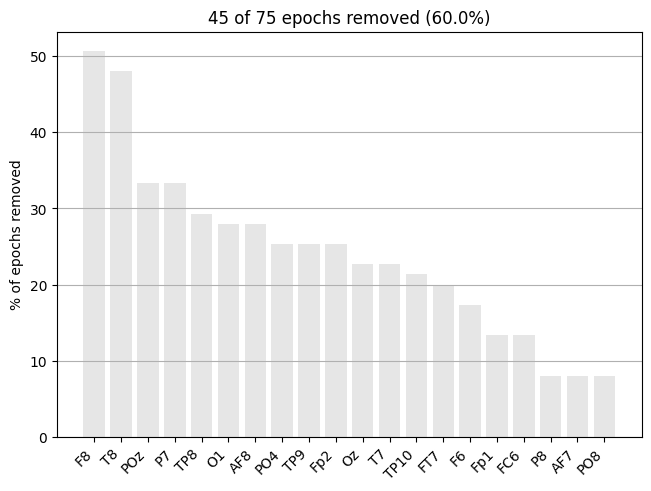

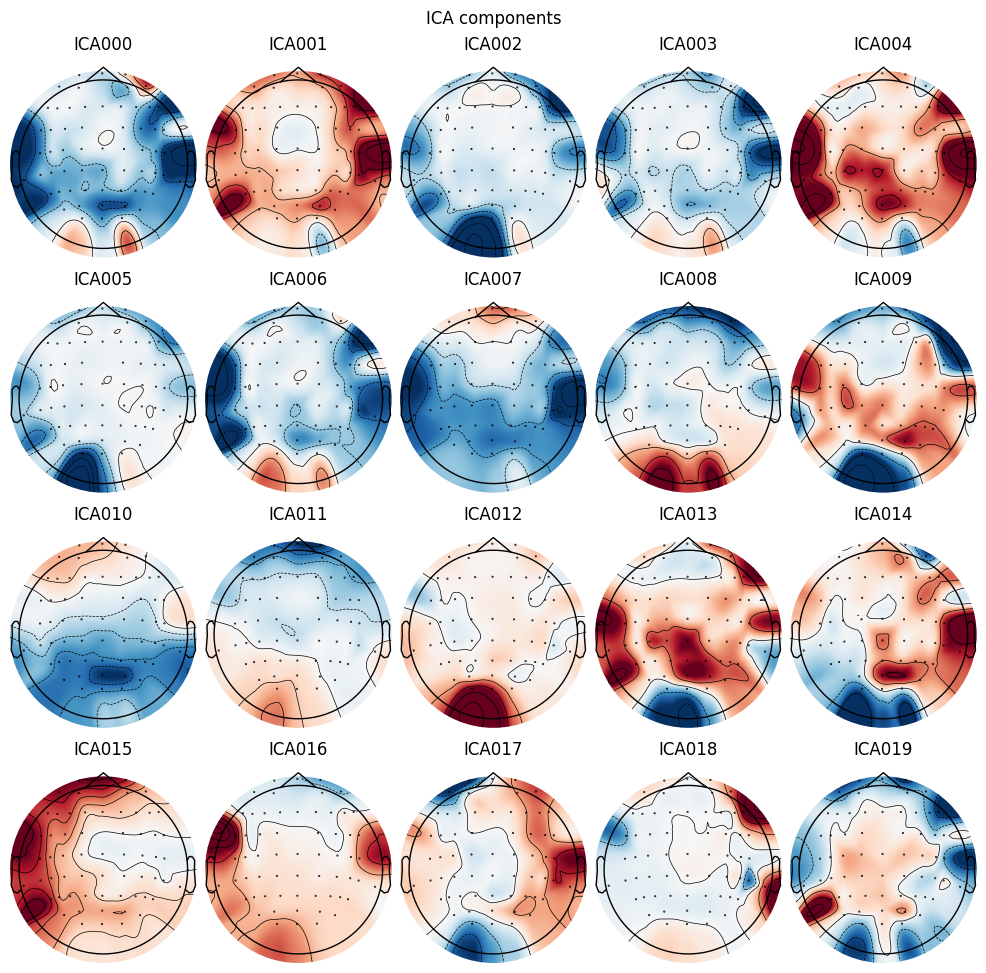


Summary of Epoch Rejection:
Total Datasets Processed: 142
Datasets with All Epochs Rejected: 1
Total SD Rejected Epochs: 1105
5106
5237
Total Normal Rejected Epochs: 917
Percentage of SD Rejected Epochs: 21.64%
Percentage of Normal Rejected Epochs: 17.51%


In [34]:
epochs.plot_drop_log()
ica.plot_components()

print("\nSummary of Epoch Rejection:")
print(f"Total Datasets Processed: {2 * 71}")  # 71 subjects × 2 sessions
print(f"Datasets with All Epochs Rejected: {datasets_with_all_epochs_rejected}")
print(f"Total SD Rejected Epochs: {total_rejected_epochs_SD}")
print(total_epochs_SD)
print(total_epochs_normal)
print(f"Total Normal Rejected Epochs: {total_rejected_epochs_normal}")
print(f"Percentage of SD Rejected Epochs: {100 * total_rejected_epochs_SD / total_epochs_SD:.2f}%")
print(f"Percentage of Normal Rejected Epochs: {100 * total_rejected_epochs_normal / total_epochs_normal:.2f}%")


In [1]:
plt.figure(figsize=(8, 6))
plt.plot(freqs, 10 * np.log10(mean_normal), label='Normal Sleep', color='magenta')
plt.fill_between(freqs, 10 * np.log10(mean_normal - sem_normal), 10 * np.log10(mean_normal + sem_normal), color='magenta', alpha=0.3)

plt.plot(freqs, 10 * np.log10(mean_sd), label='Sleep Deprivation', color='green')
plt.fill_between(freqs, 10 * np.log10(mean_sd - sem_sd), 10 * np.log10(mean_sd + sem_sd), color='green', alpha=0.3)

plt.xlabel('Frequency (Hz)')
plt.ylabel('Absolute Power (dB)')
plt.title('Comparison of Power Spectrum')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined